In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [65]:
df1 = pd.read_csv("data/go_emotion_1.csv")
df2 = pd.read_csv("data/go_emotion_2.csv")
emotions = pd.read_csv("data/emotion_mappings.csv")

df = pd.concat([df1, df2], axis=0, ignore_index=True)

df = df[df['emotion_id'].str.contains(",") != True][["text", "emotion_id"]]
df["emotion_id"] =  df['emotion_id'].astype("int")
df = df[df["text"].str.len() > 10]


In [66]:
# Mapping the emotions to their ids

df = pd.merge(df, emotions, how="left", left_on="emotion_id", right_on="id").drop(["emotion_id", "id"], axis=1)

Min:  1
Average:  12.753
Max:  32


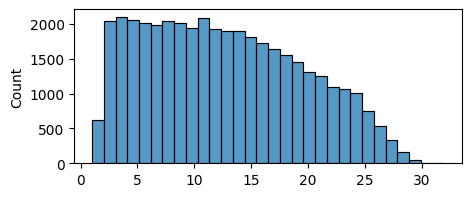

In [67]:
def text_length_distribution(df):
    sentence_length = []

    for text in df[df.columns[0]]:
        sentence_length.append(len(text.split()))
    
    print("Min: ", min(sentence_length))
    print("Average: ", round(sum(sentence_length) / len(sentence_length), 3))
    print("Max: ", max(sentence_length))
    
    plt.figure(figsize=(5, 2))
    sns.histplot(sentence_length, bins=30)

text_length_distribution(df)

In [68]:
df["emotions"].value_counts()

neutral           14151
admiration         3017
approval           2088
gratitude          2071
amusement          1814
annoyance          1639
disapproval        1587
love               1557
curiosity          1553
anger              1138
optimism            962
confusion           953
joy                 938
sadness             915
surprise            798
disappointment      792
caring              726
realization         674
disgust             568
excitement          556
fear                494
desire              444
remorse             395
embarrassment       225
relief               95
nervousness          95
pride                57
grief                41
Name: emotions, dtype: int64

In [69]:
# Filtering the data which will not be usefull in the production scenario.

required_data = ['anger','fear','realization','sadness','joy']
no_usecase_emotions = list(set(df["emotions"].unique()).difference(required_data))

for emotion in no_usecase_emotions:
    df = df[df["emotions"] != emotion]


df["emotions"].unique()

array(['anger', 'fear', 'joy', 'sadness', 'realization'], dtype=object)

In [70]:
anger = df[df["emotions"] == "anger"].sample(700)
df = df[df["emotions"] != "anger"]

df = pd.concat([df, anger], axis=0, ignore_index=True)

In [71]:
stopWords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def nlpTextProcessor(sentence):
    tokenizedSent = word_tokenize(sentence)
    removedStopwords = [word for word in tokenizedSent if word not in stopWords]
    finalOutput = []
    tempOutput = []
    for word in removedStopwords:
        if word not in set("``{['?/]}().,:-@") and word not in ["''"]:
            tempOutput.append(lemmatizer.lemmatize(word))
    finalOutput = " ".join(tempOutput)
    return finalOutput.lower()


df["text"] = df["text"].apply(nlpTextProcessor)

In [72]:
X = df["text"]
y = df["emotions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
count_vector = CountVectorizer(ngram_range=(1, 3))

X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)

In [73]:
model = MultinomialNB(alpha=1, fit_prior=False)
model.fit(X_train, y_train)

nb_predictions = model.predict(X_test)
print(classification_report(y_test, nb_predictions, zero_division=False))

              precision    recall  f1-score   support

       anger       0.82      0.62      0.71       140
        fear       0.73      0.58      0.64        99
         joy       0.73      0.87      0.79       188
 realization       0.65      0.49      0.56       135
     sadness       0.62      0.79      0.69       183

    accuracy                           0.70       745
   macro avg       0.71      0.67      0.68       745
weighted avg       0.70      0.70      0.69       745



In [74]:
def real_world_testing(texts):
    vectorized_texts = count_vector.transform(texts[1:])
    correct_predications = 0
    print("\n\n")
    for i, text in enumerate(vectorized_texts):
        print(str(i+1)+". ",texts[i+1])
        predictions = model.predict(text)
        print("----> Prediction: ", predictions[0], "\n")
        
        if str(predictions[0]) == texts[0]:
            correct_predications += 1

    print("Accuracy: ", round((correct_predications/(len(texts)-1)) * 100,0), "%")

In [75]:
data = ["test",
    "I feel like I'm floating on air, so happy and excited!",
    "Everything feels brighter; I can't stop smiling.",
    "Lost in thoughts, feeling grateful for the smallest things.",
    "I can't make sense of anything; it's all a jumble in my head.",
    "It's like a heavy weight on my chest; can't hold back the tears.",
    "Something's bothering me, but I can't quite put my finger on it.",
    "Finally, a moment of peace; the world seems quieter now.",
    "Unexpected kindness; my heart feels lighter, like a burden lifted.",
    "The tension's gone; relief floods over me, like a deep breath.",
    "Nostalgia's hitting hard; memories flooding in, bittersweet."
]


real_world_testing(data)




1.  I feel like I'm floating on air, so happy and excited!
----> Prediction:  joy 

2.  Everything feels brighter; I can't stop smiling.
----> Prediction:  anger 

3.  Lost in thoughts, feeling grateful for the smallest things.
----> Prediction:  sadness 

4.  I can't make sense of anything; it's all a jumble in my head.
----> Prediction:  realization 

5.  It's like a heavy weight on my chest; can't hold back the tears.
----> Prediction:  joy 

6.  Something's bothering me, but I can't quite put my finger on it.
----> Prediction:  sadness 

7.  Finally, a moment of peace; the world seems quieter now.
----> Prediction:  joy 

8.  Unexpected kindness; my heart feels lighter, like a burden lifted.
----> Prediction:  sadness 

9.  The tension's gone; relief floods over me, like a deep breath.
----> Prediction:  joy 

10.  Nostalgia's hitting hard; memories flooding in, bittersweet.
----> Prediction:  sadness 

Accuracy:  0.0 %
